Starting evaluation...
Initializing recommendation model...
Loading similarity matrix and metadata...
Creating product ID mapping...
Loaded similarity matrix shape: (44446, 44446)
Number of products in metadata: 44446
Number of mapped product IDs: 44446

Preparing test data...
Created 16 test cases

Evaluating for k=5

Results for k=5:
--------------------------------------------------
precision@5: 0.0125
recall@5: 0.0083
ndcg@5: 0.0175
diversity@5: 0.2125
category_accuracy@5: 0.9950

Evaluating for k=10

Results for k=10:
--------------------------------------------------
precision@10: 0.0250
recall@10: 0.0364
ndcg@10: 0.0301
diversity@10: 0.1188
category_accuracy@10: 0.9850

Evaluating for k=15

Results for k=15:
--------------------------------------------------
precision@15: 0.0292
recall@15: 0.0614
ndcg@15: 0.0419
diversity@15: 0.1083
category_accuracy@15: 0.9800


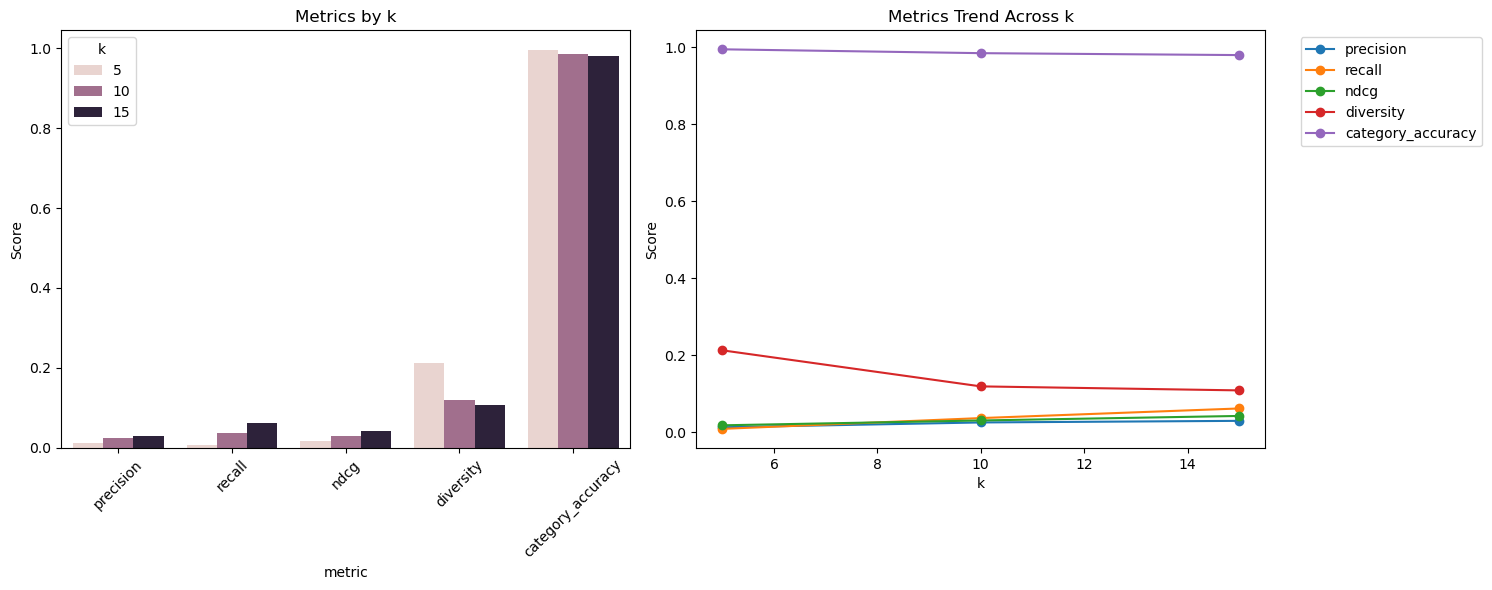

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Add project root to Python path if needed
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

from src.get_recommendations import RecommendationGenerator

def precision_recall_at_k(recommended_items, relevant_items, k=5):
    """Calculate precision and recall at k"""
    if not recommended_items or not relevant_items:
        return 0.0, 0.0
    
    recommended_set = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    
    true_positives = len(recommended_set.intersection(relevant_set))
    precision = true_positives / k
    recall = true_positives / len(relevant_set) if relevant_set else 0.0
    
    return precision, recall

def ndcg_at_k(recommended_items, relevant_items, k=5):
    """Calculate NDCG at k"""
    if not recommended_items or not relevant_items:
        return 0.0
    
    relevance = np.zeros(k)
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            relevance[i] = 1
    
    if np.sum(relevance) == 0:
        return 0.0
    
    dcg = relevance[0] + np.sum(relevance[1:] / np.log2(np.arange(2, len(relevance) + 1)))
    
    # Calculate ideal DCG
    ideal_relevance = np.zeros(k)
    n_relevant = min(len(relevant_items), k)
    ideal_relevance[:n_relevant] = 1
    idcg = ideal_relevance[0] + np.sum(ideal_relevance[1:] / np.log2(np.arange(2, len(ideal_relevance) + 1)))
    
    return dcg / idcg if idcg > 0 else 0.0

def diversity_score(recommended_items, metadata_df):
    """Calculate diversity based on unique categories"""
    if not recommended_items:
        return 0.0
    
    categories = set()
    for item in recommended_items:
        item_data = metadata_df[metadata_df['id'].astype(str) == str(item)].iloc[0]
        category = (
            item_data['masterCategory'],
            item_data['subCategory'],
            item_data['articleType']
        )
        categories.add(category)
    
    return len(categories) / len(recommended_items)

def category_accuracy(recommended_items, input_item, metadata_df):
    """Calculate category matching accuracy"""
    if not recommended_items:
        return 0.0
    
    input_data = metadata_df[metadata_df['id'].astype(str) == str(input_item)].iloc[0]
    input_category = input_data['masterCategory']
    input_subcategory = input_data['subCategory']
    
    matching_scores = []
    for item in recommended_items:
        item_data = metadata_df[metadata_df['id'].astype(str) == str(item)].iloc[0]
        score = 0.0
        
        # Weight category matches
        if item_data['masterCategory'] == input_category:
            score += 0.6
            if item_data['subCategory'] == input_subcategory:
                score += 0.4
        
        matching_scores.append(score)
    
    return np.mean(matching_scores)

def prepare_test_data(metadata_df, n_samples=100):
    """Create more challenging test data"""
    test_data = []
    
    # Group by broader categories to create more diverse test sets
    groups = metadata_df.groupby('masterCategory')
    
    for _, group in groups:
        if len(group) >= 20:  # Need enough items
            # Get all subcategories in this master category
            subcategories = group['subCategory'].unique()
            
            for _ in range(min(5, len(subcategories))):
                # Select random subcategory
                subcat = np.random.choice(subcategories)
                subcat_items = group[group['subCategory'] == subcat]['id'].astype(str).tolist()
                
                if len(subcat_items) >= 5:
                    # Select input item
                    input_item = np.random.choice(subcat_items)
                    
                    # Get relevant items:
                    # 1. Same subcategory (high relevance)
                    same_subcat = [item for item in subcat_items if item != input_item]
                    # 2. Same master category but different subcategory (medium relevance)
                    diff_subcat = group[group['subCategory'] != subcat]['id'].astype(str).tolist()
                    
                    relevant_items = {
                        'high_relevance': same_subcat[:5],
                        'medium_relevance': np.random.choice(diff_subcat, size=min(5, len(diff_subcat)), replace=False).tolist()
                    }
                    
                    test_data.append((input_item, relevant_items))
                    
                if len(test_data) >= n_samples:
                    break
        
        if len(test_data) >= n_samples:
            break
    
    print(f"Created {len(test_data)} test cases")
    return test_data

def evaluate_recommendations(model, test_data, metadata_df, k=5):
    """Evaluate with more nuanced relevance judgments"""
    total_precision = 0
    total_recall = 0
    total_ndcg = 0
    total_diversity = 0
    total_category_acc = 0
    valid_count = 0
    
    for input_item, relevant_items in test_data:
        try:
            results = model.get_recommendations([input_item], k=k)
            if not results or input_item not in results:
                continue
            
            recommendations = results[input_item]['recommendations']
            recommended_ids = [rec['product_id'] for rec in recommendations]
            
            # Calculate precision and recall with weighted relevance
            high_rel_set = set(relevant_items['high_relevance'])
            med_rel_set = set(relevant_items['medium_relevance'])
            
            precision = sum((1.0 if rid in high_rel_set else 0.5 if rid in med_rel_set else 0) 
                          for rid in recommended_ids[:k]) / k
            
            recall = sum((1.0 if rid in high_rel_set else 0.5 if rid in med_rel_set else 0) 
                        for rid in recommended_ids[:k]) / (len(high_rel_set) + 0.5 * len(med_rel_set))
            
            # Calculate NDCG with graded relevance
            relevance = np.array([1.0 if rid in high_rel_set else 0.5 if rid in med_rel_set else 0
                                for rid in recommended_ids[:k]])
            
            dcg = relevance[0] + np.sum(relevance[1:] / np.log2(np.arange(2, len(relevance) + 1)))
            
            # Ideal ranking would have all high relevance items first, then medium
            ideal_relevance = np.zeros(k)
            n_high = min(len(high_rel_set), k)
            n_med = min(len(med_rel_set), k - n_high)
            ideal_relevance[:n_high] = 1.0
            ideal_relevance[n_high:n_high + n_med] = 0.5
            
            idcg = ideal_relevance[0] + np.sum(ideal_relevance[1:] / np.log2(np.arange(2, len(ideal_relevance) + 1)))
            ndcg = dcg / idcg if idcg > 0 else 0
            
            # Calculate diversity and category accuracy
            diversity = diversity_score(recommended_ids, metadata_df)
            cat_acc = category_accuracy(recommended_ids, input_item, metadata_df)
            
            # Accumulate metrics
            total_precision += precision
            total_recall += recall
            total_ndcg += ndcg
            total_diversity += diversity
            total_category_acc += cat_acc
            valid_count += 1
            
        except Exception as e:
            print(f"Error evaluating item {input_item}: {str(e)}")
            continue
    
    if valid_count == 0:
        raise ValueError("No valid recommendations generated during evaluation")
    
    return {
        f'precision@{k}': total_precision / valid_count,
        f'recall@{k}': total_recall / valid_count,
        f'ndcg@{k}': total_ndcg / valid_count,
        f'diversity@{k}': total_diversity / valid_count,
        f'category_accuracy@{k}': total_category_acc / valid_count
    }

def plot_results(results, k_values):
    """Plot evaluation results"""
    metrics_data = []
    for k in k_values:
        for metric, value in results[k].items():
            metric_name = metric.split('@')[0]
            metrics_data.append({
                'k': k,
                'metric': metric_name,
                'value': value
            })
    
    df = pd.DataFrame(metrics_data)
    
    plt.figure(figsize=(15, 6))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    sns.barplot(data=df, x='metric', y='value', hue='k')
    plt.title('Metrics by k')
    plt.xticks(rotation=45)
    plt.ylabel('Score')
    
    # Line plot
    plt.subplot(1, 2, 2)
    for metric in df['metric'].unique():
        metric_data = df[df['metric'] == metric]
        plt.plot(metric_data['k'], metric_data['value'], 
                marker='o', label=metric)
    
    plt.title('Metrics Trend Across k')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

def run_evaluation(n_test_cases=100, k_values=[5, 10, 15]):
    """Run complete evaluation of recommendation system"""
    try:
        # Initialize model
        print("Initializing recommendation model...")
        model = RecommendationGenerator(
            similarity_matrix_path='data/content_similarity.npy',
            metadata_path='data/styles.csv'
        )
        
        # Prepare test data
        print("\nPreparing test data...")
        test_data = prepare_test_data(model.metadata, n_test_cases)
        
        # Evaluate for different k values
        results = {}
        for k in k_values:
            print(f"\nEvaluating for k={k}")
            metrics = evaluate_recommendations(model, test_data, model.metadata, k=k)
            results[k] = metrics
            
            # Print results
            print(f"\nResults for k={k}:")
            print("-" * 50)
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
        
        # Plot results
        plot_results(results, k_values)
        return results
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Run evaluation
print("Starting evaluation...")
results = run_evaluation(n_test_cases=50, k_values=[5, 10, 15])